# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


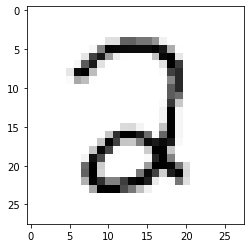

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2183
Training Accuracy: 0.7835, Testing Accuracy: 0.7863



Epoch 10, Loss 0.0766
Training Accuracy: 0.9236, Testing Accuracy: 0.9360



Epoch 20, Loss 0.05
Training Accuracy: 0.9472, Testing Accuracy: 0.9567



Epoch 30, Loss 0.0405
Training Accuracy: 0.9549, Testing Accuracy: 0.9647



Epoch 40, Loss 0.0357
Training Accuracy: 0.9584, Testing Accuracy: 0.9672



Epoch 50, Loss 0.0328
Training Accuracy: 0.9617, Testing Accuracy: 0.9677



Epoch 60, Loss 0.0308
Training Accuracy: 0.9641, Testing Accuracy: 0.9708



Epoch 70, Loss 0.0292
Training Accuracy: 0.9658, Testing Accuracy: 0.9698



Epoch 80, Loss 0.0279
Training Accuracy: 0.9668, Testing Accuracy: 0.9693



Epoch 90, Loss 0.0268
Training Accuracy: 0.9685, Testing Accuracy: 0.9698



Epoch 100, Loss 0.0259
Training Accuracy: 0.9699, Testing Accuracy: 0.9703



Epoch 110, Loss 0.025
Training Accuracy: 0.9707, Testing Accuracy: 0.9703



Epoch 120, Loss 0.0243
Training Accuracy: 0.9718, Testing Accuracy: 0.9703



Epoch 130, Loss 0.0236
Training Accuracy: 0.9726, Testing Accuracy: 0.9708



Epoch 140, Loss 0.023
Training Accuracy: 0.9733, Testing Accuracy: 0.9718



Epoch 150, Loss 0.0224
Training Accuracy: 0.9736, Testing Accuracy: 0.9713



Epoch 160, Loss 0.0218
Training Accuracy: 0.9745, Testing Accuracy: 0.9723



Epoch 170, Loss 0.0213
Training Accuracy: 0.9756, Testing Accuracy: 0.9723



Epoch 180, Loss 0.0207
Training Accuracy: 0.9764, Testing Accuracy: 0.9733



Epoch 190, Loss 0.0202
Training Accuracy: 0.9768, Testing Accuracy: 0.9743



Epoch 200, Loss 0.0197
Training Accuracy: 0.9778, Testing Accuracy: 0.9738



Epoch 210, Loss 0.0193
Training Accuracy: 0.9785, Testing Accuracy: 0.9728



Epoch 220, Loss 0.0188
Training Accuracy: 0.9793, Testing Accuracy: 0.9738



Epoch 230, Loss 0.0184
Training Accuracy: 0.9797, Testing Accuracy: 0.9748



Epoch 240, Loss 0.018
Training Accuracy: 0.9805, Testing Accuracy: 0.9753



0.03946846215570271

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.2141
Training Accuracy: 0.8148, Testing Accuracy: 0.8332



Epoch 10, Loss 0.0992
Training Accuracy: 0.9140, Testing Accuracy: 0.9274



Epoch 20, Loss 0.0781
Training Accuracy: 0.9290, Testing Accuracy: 0.9400



Epoch 30, Loss 0.068
Training Accuracy: 0.9354, Testing Accuracy: 0.9466



Epoch 40, Loss 0.0618
Training Accuracy: 0.9404, Testing Accuracy: 0.9536



Epoch 50, Loss 0.0575
Training Accuracy: 0.9432, Testing Accuracy: 0.9567



Epoch 60, Loss 0.0543
Training Accuracy: 0.9458, Testing Accuracy: 0.9561



Epoch 70, Loss 0.0518
Training Accuracy: 0.9478, Testing Accuracy: 0.9587



Epoch 80, Loss 0.0497
Training Accuracy: 0.9492, Testing Accuracy: 0.9602



Epoch 90, Loss 0.0481
Training Accuracy: 0.9504, Testing Accuracy: 0.9622



Epoch 100, Loss 0.0466
Training Accuracy: 0.9516, Testing Accuracy: 0.9637



Epoch 110, Loss 0.0454
Training Accuracy: 0.9523, Testing Accuracy: 0.9632



Epoch 120, Loss 0.0443
Training Accuracy: 0.9529, Testing Accuracy: 0.9642



Epoch 130, Loss 0.0434
Training Accuracy: 0.9542, Testing Accuracy: 0.9642



Epoch 140, Loss 0.0426
Training Accuracy: 0.9549, Testing Accuracy: 0.9647



Epoch 150, Loss 0.0418
Training Accuracy: 0.9556, Testing Accuracy: 0.9647



Epoch 160, Loss 0.0411
Training Accuracy: 0.9562, Testing Accuracy: 0.9657



Epoch 170, Loss 0.0405
Training Accuracy: 0.9568, Testing Accuracy: 0.9667



Epoch 180, Loss 0.0399
Training Accuracy: 0.9573, Testing Accuracy: 0.9667



Epoch 190, Loss 0.0394
Training Accuracy: 0.9580, Testing Accuracy: 0.9672



Epoch 200, Loss 0.0389
Training Accuracy: 0.9588, Testing Accuracy: 0.9672



Epoch 210, Loss 0.0385
Training Accuracy: 0.9591, Testing Accuracy: 0.9672



Epoch 220, Loss 0.038
Training Accuracy: 0.9598, Testing Accuracy: 0.9672



Epoch 230, Loss 0.0376
Training Accuracy: 0.9599, Testing Accuracy: 0.9672



Epoch 240, Loss 0.0373
Training Accuracy: 0.9600, Testing Accuracy: 0.9672



0.027003248707851604

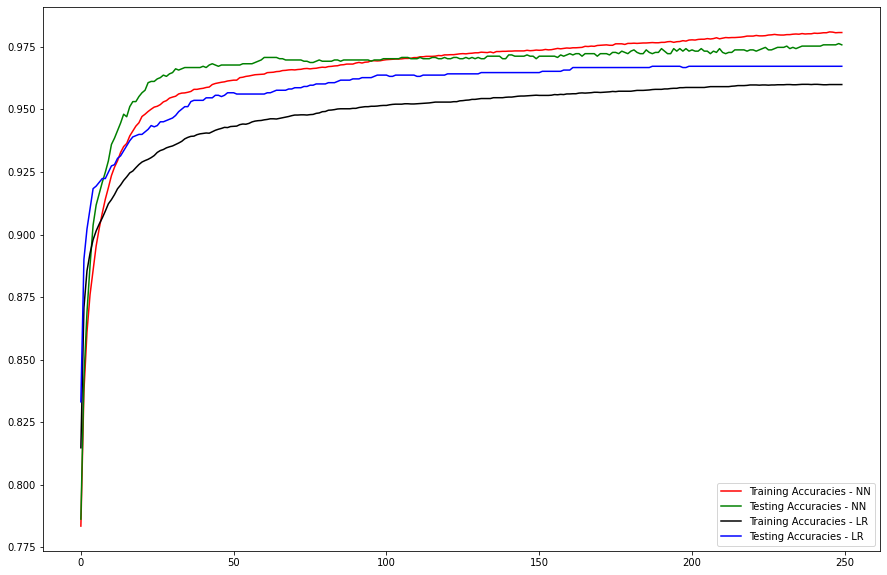

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

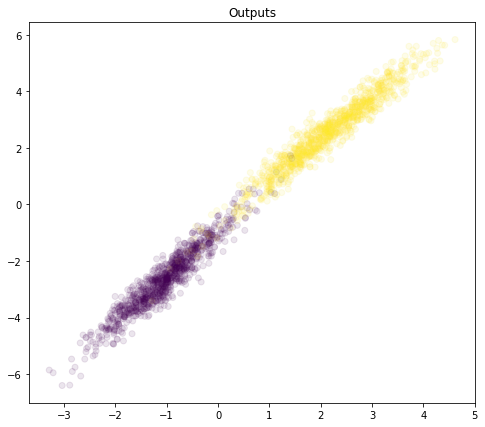

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

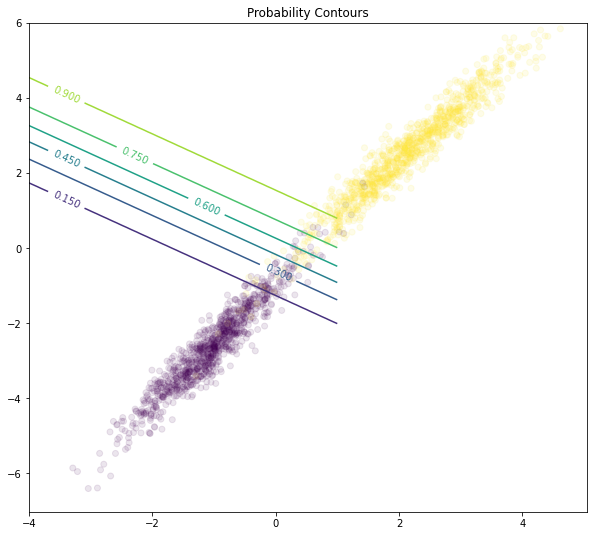

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );